In [11]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [12]:
# single site operators

x_plus_1 = np.array(np.matrix([[0,0,0],[0,0,0],[0,1,0]]))
x_minus_1 = np.array(np.matrix([[0,0,0],[0,0,1],[0,0,0]]))
x_plus_2 = np.array(np.matrix([[0,1,0],[0,0,0],[0,0,0]]))
x_minus_2 = np.array(np.matrix([[0,0,0],[1,0,0],[0,0,0]]))

T_plus_1_1 = np.array(np.matrix([[0,0,0],[0,1,0],[0,0,-1]]))
T_minus_1_1 = T_plus_1_1
T_plus_1_2 = np.array(np.matrix([[0,0,0],[0,0,0],[-1,0,0]]))
T_minus_1_2 = np.array(np.matrix([[0,0,-1],[0,0,0],[0,0,0]]))
T_plus_2_1 = T_minus_1_2
T_minus_2_1 = T_plus_1_2
T_plus_2_2 = np.array(np.matrix([[-1,0,0],[0,1,0],[0,0,0]]))
T_minus_2_2 = T_plus_2_2

id = np.eye(3)

In [13]:
# manual operator definitions for two sites

psi_plus_1_1 = np.kron(x_plus_1,id)
psi_minus_1_1 = np.kron(x_minus_1,id)
psi_plus_1_2 = np.kron(x_plus_2,id)
psi_minus_1_2 = np.kron(x_minus_2,id)

psi_plus_2_1 = np.kron(T_plus_1_1, x_plus_1) + np.kron(T_plus_1_2, x_plus_2)
psi_minus_2_1 = np.kron(T_minus_1_1, x_minus_1) + np.kron(T_minus_1_2, x_minus_2)
psi_plus_2_2 = np.kron(T_plus_2_1, x_plus_1) + np.kron(T_plus_2_2, x_plus_2)
psi_minus_2_2 = np.kron(T_minus_2_1, x_minus_1) + np.kron(T_minus_2_2, x_minus_2)

n_1 = psi_plus_1_1 @ psi_minus_1_1 + psi_plus_1_2 @ psi_minus_1_2
n_2 = psi_plus_2_1 @ psi_minus_2_1 + psi_plus_2_2 @ psi_minus_2_2
total_n = n_1 + n_2

In [14]:
"""import numpy as np
from itertools import product

# Identity for single site
id3 = np.eye(3)

# Define x^{(±)}_{i,alpha}
x_matrices = {
    ('+', 1): np.array([[0, 0, 0], [0, 0, 0], [0, 1, 0]]),
    ('-', 1): np.array([[0, 0, 0], [0, 0, 1], [0, 0, 0]]),
    ('+', 2): np.array([[0, 1, 0], [0, 0, 0], [0, 0, 0]]),
    ('-', 2): np.array([[0, 0, 0], [1, 0, 0], [0, 0, 0]]),
}

# Define T^{(±)}_{k,alpha,beta}
T_matrices = {
    ('+', 1, 1): np.array([[0, 0, 0], [0, 1, 0], [0, 0, -1]]),
    ('-', 1, 1): np.array([[0, 0, 0], [0, 1, 0], [0, 0, -1]]),
    ('+', 1, 2): np.array([[0, 0, 0], [0, 0, 0], [-1, 0, 0]]),
    ('-', 1, 2): np.array([[0, 0, -1], [0, 0, 0], [0, 0, 0]]),
    ('+', 2, 1): np.array([[0, 0, -1], [0, 0, 0], [0, 0, 0]]),
    ('-', 2, 1): np.array([[0, 0, 0], [0, 0, 0], [-1, 0, 0]]),
    ('+', 2, 2): np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 0]]),
    ('-', 2, 2): np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 0]]),
}

def build_paraparticle_operator(N, site_index, alpha, sign):
    assert 1 <= site_index <= N
    assert alpha in [1, 2]
    assert sign in ['+', '-']

    total_op = np.zeros((3**N, 3**N))

    # Generate all beta chains of length (site_index - 1)
    for beta_chain in product([1, 2], repeat=site_index - 1):
        op_list = []

        # Construct the x^{(sign)}_{i,beta_{i-1}} part
        beta_prev = beta_chain[-1] if beta_chain else alpha
        x_op = x_matrices[(sign, beta_prev)]
        op_list.append(x_op)

        # Build T^{(sign)} chain in reverse site order
        for k in reversed(range(site_index - 1)):
            beta_k = beta_chain[k]
            beta_k_minus_1 = alpha if k == 0 else beta_chain[k - 1]
            T_k = T_matrices[(sign, beta_k_minus_1, beta_k)]
            op_list.insert(0, T_k)  # prepend

        # Pad identity operators
        full_op_list = (
            [id3] * (site_index - len(op_list)) + op_list + [id3] * (N - site_index)
        )

        # Compute full Kronecker product
        kron_op = full_op_list[0]
        for m in range(1, len(full_op_list)):
            kron_op = np.kron(kron_op, full_op_list[m])

        total_op += kron_op

    return total_op


def construct_site_paraparticle_n_operator(N, site_index):
    assert 1 <= site_index <= N
    n_i = np.zeros((3**N, 3**N))

    for alpha in [1, 2]:
        psi_plus = build_paraparticle_operator(N, site_index, alpha, '+')
        psi_minus = build_paraparticle_operator(N, site_index, alpha, '-')
        n_i += psi_plus @ psi_minus

    return n_i

def construct_total_paraparticle_n_operator(N):
    total_n = np.zeros((3**N, 3**N))
    for i in range(1, N + 1):
        total_n += construct_site_paraparticle_n_operator(N, i)
    return total_n
"""

"import numpy as np\nfrom itertools import product\n\n# Identity for single site\nid3 = np.eye(3)\n\n# Define x^{(±)}_{i,alpha}\nx_matrices = {\n    ('+', 1): np.array([[0, 0, 0], [0, 0, 0], [0, 1, 0]]),\n    ('-', 1): np.array([[0, 0, 0], [0, 0, 1], [0, 0, 0]]),\n    ('+', 2): np.array([[0, 1, 0], [0, 0, 0], [0, 0, 0]]),\n    ('-', 2): np.array([[0, 0, 0], [1, 0, 0], [0, 0, 0]]),\n}\n\n# Define T^{(±)}_{k,alpha,beta}\nT_matrices = {\n    ('+', 1, 1): np.array([[0, 0, 0], [0, 1, 0], [0, 0, -1]]),\n    ('-', 1, 1): np.array([[0, 0, 0], [0, 1, 0], [0, 0, -1]]),\n    ('+', 1, 2): np.array([[0, 0, 0], [0, 0, 0], [-1, 0, 0]]),\n    ('-', 1, 2): np.array([[0, 0, -1], [0, 0, 0], [0, 0, 0]]),\n    ('+', 2, 1): np.array([[0, 0, -1], [0, 0, 0], [0, 0, 0]]),\n    ('-', 2, 1): np.array([[0, 0, 0], [0, 0, 0], [-1, 0, 0]]),\n    ('+', 2, 2): np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 0]]),\n    ('-', 2, 2): np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 0]]),\n}\n\ndef build_paraparticle_operator(N, site_inde

In [50]:
# at J/V = 0

N = 2
M = 3
V = 1

J_V_ratio = 0
mu_V_ratio = 0

eigenstate_key = []
occupations_1 = []
occupations_2 = []
total_occupations = []

hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio, J_V_ratio)
eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)

for i, state in enumerate(eigenvectors):
    eigenstate_key += [i]
    occupations_1 += [state.conj().T @ n_1 @ state]    
    occupations_2 += [state.conj().T @ n_2 @ state]
    total_occupations += [state.conj().T @ total_n @ state]
    

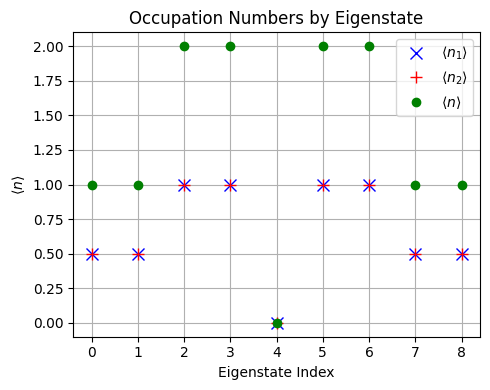

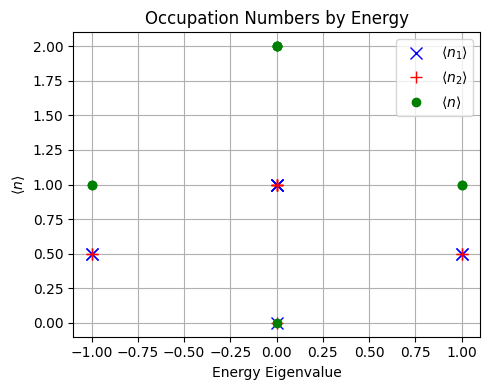

In [ ]:
# show these plots for one-on-one 5/28/2025

fig, ax = plt.subplots(figsize = (5,4))
ax.plot(eigenstate_key, occupations_1, 'xb', markersize = 8,  label = "$\langle n_1 \\rangle$")
ax.plot(eigenstate_key, occupations_2, '+r', markersize = 8, label = "$\langle n_2 \\rangle$")
ax.plot(eigenstate_key, total_occupations, "og", markersize = 6, label = "$\langle n \\rangle$")
ax.legend()
ax.grid()
ax.set_title("Occupation Numbers by Eigenstate")
ax.set_xlabel("Eigenstate Index")
ax.set_ylabel("$\langle n \\rangle$")
fig.tight_layout()

fig, ax = plt.subplots(figsize = (5,4))
ax.plot(eigenvalues, occupations_1, 'xb', markersize = 8,  label = "$\langle n_1 \\rangle$")
ax.plot(eigenvalues, occupations_2, '+r', markersize = 8, label = "$\langle n_2 \\rangle$")
ax.plot(eigenvalues, total_occupations, "og", markersize = 6, label = "$\langle n \\rangle$")
ax.legend()
ax.grid()
ax.set_title("Occupation Numbers by Energy")
ax.set_xlabel("Energy Eigenvalue")
ax.set_ylabel("$\langle n \\rangle$")
fig.tight_layout()



In [15]:
# around J/V = 0
N = 2
M = 3
V = 1

J_V_ratios = np.linspace(0,0.5,100)

occupations_1 = []
occupations_2 = []
total_occupations = []

for J_V_ratio in J_V_ratios:
    hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio = 0, J_V_ratio = J_V_ratio)
    eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)
    
    occupation_1_by_state = []
    occupation_2_by_state = []
    total_occupations_by_state = []

    for state in eigenvectors:
        occ1 = state.T.conj() @ n_1 @ state
        occ2 = state.T.conj() @ n_2 @ state
        occ = state.T.conj() @ total_n @ state
        occupation_1_by_state.append(occ1)
        occupation_2_by_state.append(occ2)
        total_occupations_by_state.append(occ)
        
    occupations_1.append(occupation_1_by_state)
    occupations_2.append(occupation_2_by_state)
    total_occupations.append(total_occupations_by_state)
    
occupations_1 = np.array(occupations_1)
occupations_2 = np.array(occupations_2)
total_occupations = np.array(total_occupations)

In [16]:
colors = get_cmap("winter", M**N)
"""occupations = [occupations_1, occupations_2]


for i in range(M**N):
    fig, (ax1,ax2) = plt.subplots(figsize = (7,4), ncols = 2)
    axes = [ax1, ax2]
    for j, ax in enumerate(axes):
        ax.plot(J_V_ratios, occupations[j][:,i], color = colors(i))
        ax.plot(J_V_ratios, occupations[j][:,i], '.', color = colors(i))
        ax.set_ylim(-0.05,1.05)
        ax.set_title(f"$\langle n_{j+1} \\rangle$")
        ax.set_xlabel("$J/|V|$")
        ax.set_ylabel(f"$\langle n_{j+1} \\rangle$")
        ax.grid()
        fig.suptitle(f"Paraparticle Mode Occupations: $\phi_{i}$")
    fig.tight_layout()
    """

'occupations = [occupations_1, occupations_2]\n\n\nfor i in range(M**N):\n    fig, (ax1,ax2) = plt.subplots(figsize = (7,4), ncols = 2)\n    axes = [ax1, ax2]\n    for j, ax in enumerate(axes):\n        ax.plot(J_V_ratios, occupations[j][:,i], color = colors(i))\n        ax.plot(J_V_ratios, occupations[j][:,i], \'.\', color = colors(i))\n        ax.set_ylim(-0.05,1.05)\n        ax.set_title(f"$\\langle n_{j+1} \\rangle$")\n        ax.set_xlabel("$J/|V|$")\n        ax.set_ylabel(f"$\\langle n_{j+1} \\rangle$")\n        ax.grid()\n        fig.suptitle(f"Paraparticle Mode Occupations: $\\phi_{i}$")\n    fig.tight_layout()\n    '

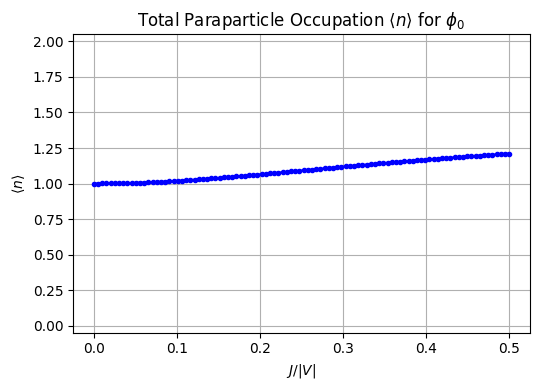

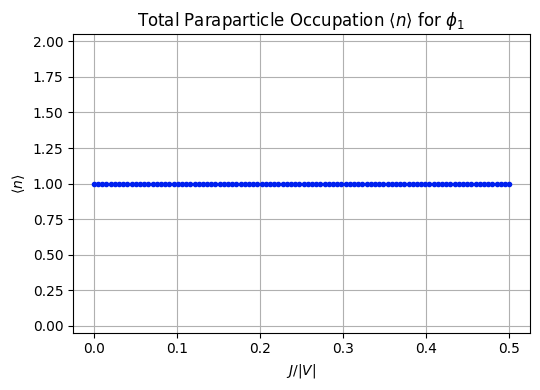

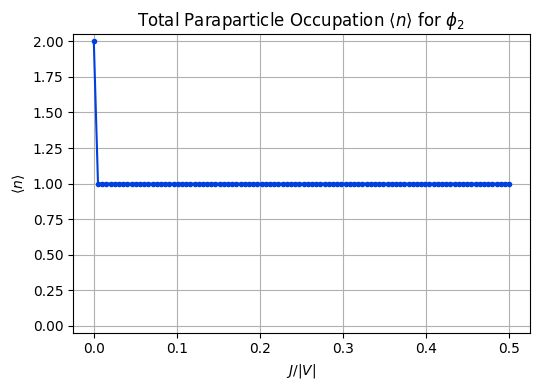

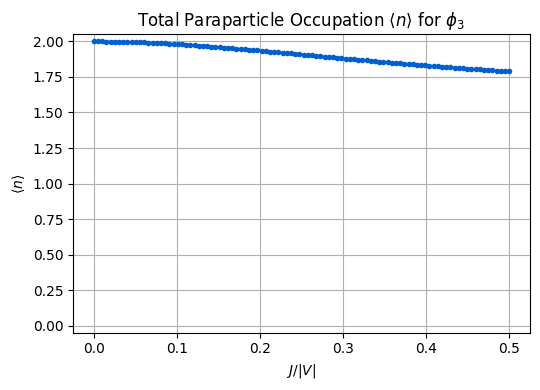

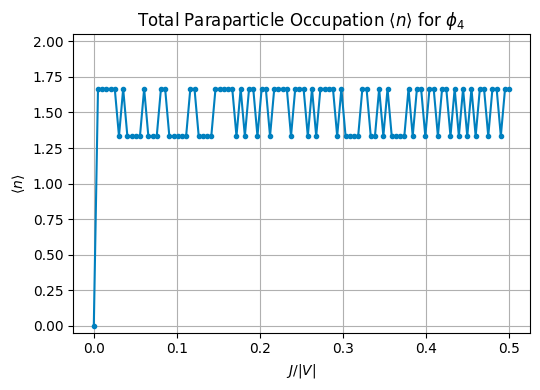

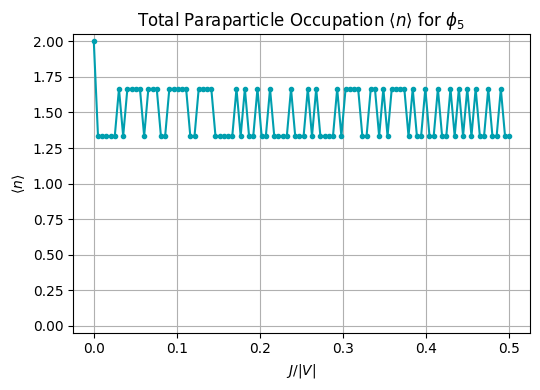

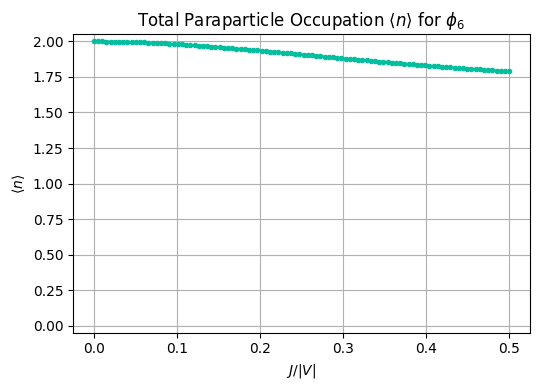

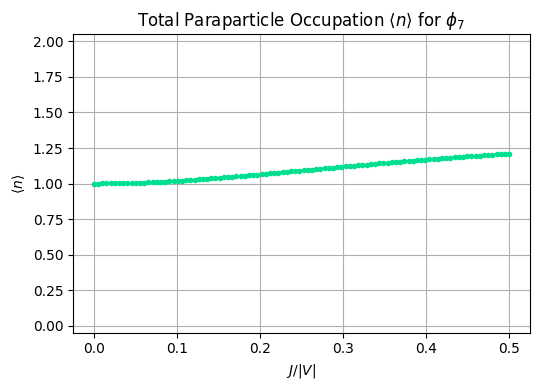

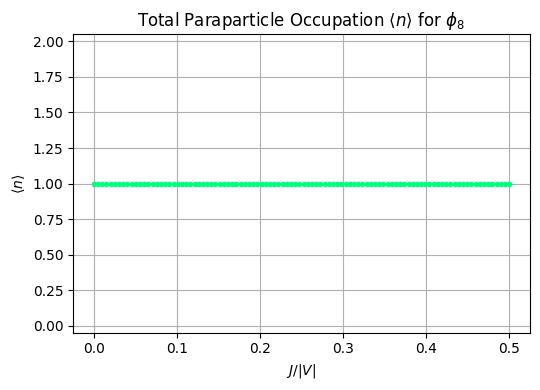

In [17]:
colors = get_cmap("winter", M**N)

for i in range(M**N):
    fig, ax = plt.subplots(figsize = (5.5,4))
    ax.plot(J_V_ratios, total_occupations[:,i], color = colors(i))
    ax.plot(J_V_ratios, total_occupations[:,i], '.', color = colors(i))
    ax.set_ylim(-0.05,2.05)
    ax.set_title(f"Total Paraparticle Occupation $\langle n \\rangle$ for $\phi_{i}$")
    ax.grid()
    ax.set_xlabel("$J/|V|$")
    ax.set_ylabel(f"$\langle n \\rangle$")
    fig.tight_layout()